In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import json
import torch
import nltk
from time import time

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.utils.extmath import density

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords         
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /home/ranamahmud/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ranamahmud/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/ranamahmud/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/ranamahmud/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
df = pd.read_csv("./Resume/Resume.csv")

# 2. Data Exploration and Preprocessing

In [3]:
# print first few rows of the data
df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


## Text exploration

In [4]:
id = np.random.randint(len(df))
df.Resume_str[id][0:100]

'         EVENT LEAD / PREP COOK / ASSISTANT PASTRY CHEF       Summary     Talented cook with a diver'

In [5]:
id = np.random.randint(len(df))
df.Resume_str[id][0:100]

'         GENERAL CONSTRUCTION INTERN       Objective     Dedicated student\xa0with excellent technical,'

In [6]:
id = np.random.randint(len(df))
df.Resume_str[id][0:100]

'         QUALITY ASSURANCE LEAD       Career Overview     Coaching & Development Technical Support A'

In [7]:
# remove words related to Category

In [8]:
category = set(df.Category.str.lower())

In [9]:
category

{'accountant',
 'advocate',
 'agriculture',
 'apparel',
 'arts',
 'automobile',
 'aviation',
 'banking',
 'bpo',
 'business-development',
 'chef',
 'construction',
 'consultant',
 'designer',
 'digital-media',
 'engineering',
 'finance',
 'fitness',
 'healthcare',
 'hr',
 'information-technology',
 'public-relations',
 'sales',
 'teacher'}

In [10]:
# def remove_words(text, words):
#     # Create a regex pattern to match the words
#     pattern = r'\b(?:' + '|'.join(map(re.escape, words)) + r')\b'
#     # Use re.sub to remove the matched words
#     return re.sub(pattern, '', text, flags=re.IGNORECASE)

In [11]:
# df['Resume_str'] = df['Resume_str'].apply(lambda x: remove_words(x, category))

### Data Leackage

There is a data leackage issue. Because Category is written in most of the CV. For this reason I've trained model removing the category target texts from the resume. But the model performance for validation and test set got bad.

{'eval_loss': 1.5424693822860718,
 'eval_accuracy': 0.5975855130784709,
 'eval_precision': 0.5890011161926136,
 'eval_recall': 0.5975855130784709,
 'eval_f1': 0.5885319850900211,
 'eval_runtime': 1.1094,
 'eval_samples_per_second': 448.0,
 'eval_steps_per_second': 14.423,
 'epoch': 14.0}
# Evaluate on test set (final evaluation)
print("Test Set Performance:")
test_results = trainer.evaluate(eval_dataset=test_dataset)
print(test_results)
Test Set Performance:
{'eval_loss': 1.5591726303100586, 'eval_accuracy': 0.5875251509054326, 'eval_precision': 0.5797803324852914, 'eval_recall': 0.5875251509054326, 'eval_f1': 0.5767517019061779, 'eval_runtime': 1.0906, 'eval_samples_per_second': 455.727, 'eval_steps_per_second': 14.671, 'epoch': 14.0}

### Model performance after remove first 100 character to prevent data leackage only in the pdf top


In [12]:
df['Resume_str'] = df['Resume_str'].apply(lambda x: x[100:] if len(x) > 100 else '')


In [13]:
# print dataframe shape
df.shape

(2484, 4)

In [14]:
# count no of unique values in each column
df.nunique()

ID             2484
Resume_str     2482
Resume_html    2482
Category         24
dtype: int64

In [15]:
# check for null values
df.isnull().sum()

ID             0
Resume_str     0
Resume_html    0
Category       0
dtype: int64

We can see that there is no null values in the dataframe

## Category column exploration

In [16]:
# Value counts
df.Category.value_counts()

Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
ADVOCATE                  118
CHEF                      118
ENGINEERING               118
ACCOUNTANT                118
FINANCE                   118
FITNESS                   117
AVIATION                  117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64

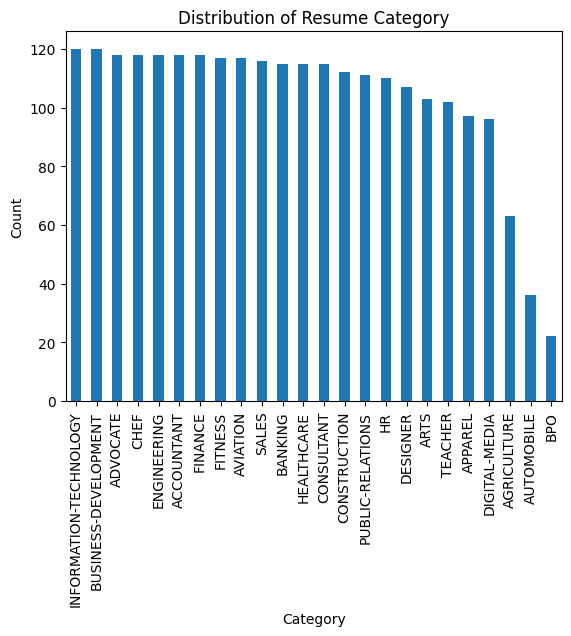

In [17]:
df.Category.value_counts().plot(kind='bar')
plt.ylabel("Count")
plt.title("Distribution of Resume Category");

From the above plot and frequency count of Category column we can see that there is a class imbalance for Resume Category.

In [18]:
df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,Service Manager with 15+ years of experience ...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"ound in Communications, Marketing, Human Resou...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,"uman Resources Executive Management, 5 years...","<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,r service expertise. Motivated to maintain cus...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,rganization Startups Employment Law FMLA/ADA...,"<div class=""fontsize fontface vmargins hmargin...",HR


## Text preprocessing

In [19]:
porter = PorterStemmer()

In [20]:
stopwords_en = set(stopwords.words('english'))
def text_preprocess(text):
    # edge case
    if not isinstance(text, str):
        return ''
    # strip whitespace
    text = text.strip()
    # tokenize
    tokens = word_tokenize(text)
    # convert to lowercase
    tokens = [word.lower() for word in tokens]
    # remove stopwords
    words = [word for word in tokens if word not in stopwords_en]
    # remove punctuation
    words = [word for word in words if word.isalpha()]
    # stem
    words = [porter.stem(word) for word in words]
    return ' '.join(words)
# apply text preprocessing
df['cleaned_resume'] = df['Resume_str'].apply(text_preprocess)

In [21]:
df.head()

,ID,Resume_str,Resume_html,Category,cleaned_resume
0,16852973,Service Manager with 15+ years of experience ...,"<div class=""fontsize fontface vmargins hmargin...",HR,servic manag year experi hospit custom servic ...
1,22323967,"ound in Communications, Marketing, Human Resou...","<div class=""fontsize fontface vmargins hmargin...",HR,ound commun market human resourc technolog exp...
2,33176873,"uman Resources Executive Management, 5 years...","<div class=""fontsize fontface vmargins hmargin...",HR,uman resourc execut manag year hri develop mai...
3,27018550,r service expertise. Motivated to maintain cus...,"<div class=""fontsize fontface vmargins hmargin...",HR,r servic expertis motiv maintain custom satisf...
4,17812897,rganization Startups Employment Law FMLA/ADA...,"<div class=""fontsize fontface vmargins hmargin...",HR,rganiz startup employ law mediat advocaci hr p...


## Training, Validation and Test split

In [22]:
# seperate feature and target
X = df.cleaned_resume
y = df.Category

In [23]:
# check X and y shape

In [24]:
X.shape

(2484,)

In [25]:
y.shape

(2484,)

70% train, 15% valid, 15% test split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, random_state=42, stratify = y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=100/85*0.15, random_state=42, stratify = y_train) # 0.25 x 0.8 = 0.2

In [27]:
X_train.shape

(1738,)

In [28]:
X_test.shape

(373,)

In [29]:
X_valid.shape

(373,)

In [30]:
# source: https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html

# Baseline Model

## Prepare Data

## Using unigram only

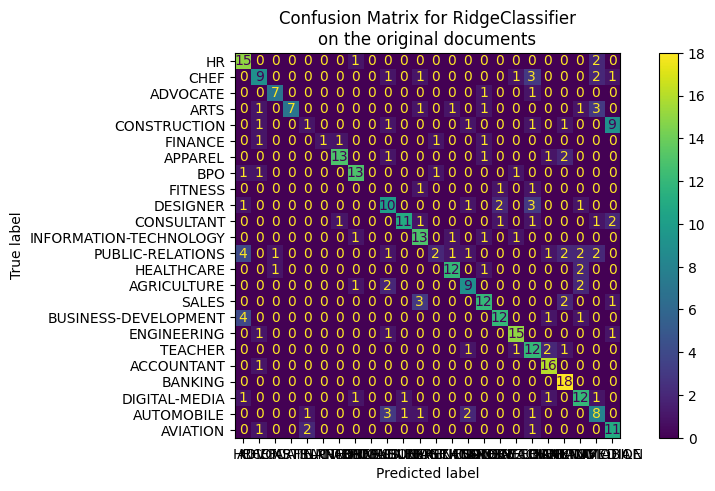

In [31]:
vectorizer = TfidfVectorizer(
        sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english"
    )

X_train = vectorizer.fit_transform(X_train)

X_valid = vectorizer.transform(X_valid)
X_test = vectorizer.transform(X_test)


clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

len(set(pred))

target_names = set(df.Category)

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non the original documents"
)

### Evaluation

In [32]:
## Acuracy, Precision, Recall, F1-Score

In [33]:
accuracy_score(y_test, pred)


print(precision_score(y_test, pred, average='macro'))
print(precision_score(y_test, pred, average='micro'))
print(precision_score(y_test, pred, average='weighted'))


print(recall_score(y_test, pred, average='macro'))
print(recall_score(y_test, pred, average='micro'))
print(recall_score(y_test, pred, average='weighted'))


print(f1_score(y_test, pred, average='macro'))
print(f1_score(y_test, pred, average='micro'))
print(f1_score(y_test, pred, average='weighted'))

def benchmark(clf, custom_name=False):
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print(f"train time: {train_time:.3}s")

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print(f"test time:  {test_time:.3}s")

    score = metrics.accuracy_score(y_test, pred)
    print(f"accuracy:   {score:.3}")
    f1_score_macro = f1_score(y_test, pred, average='macro')
    f1_score_micro = f1_score(y_test, pred, average='micro')
    f1_score_weighted = f1_score(y_test, pred, average='weighted')
    print(f"f1_score macro:   {f1_score_macro:.3}")
    print(f"f1_score micro:   {f1_score_micro:.3}")
    print(f"f1_score weighted:   {f1_score_weighted:.3}")
    
    
    if hasattr(clf, "coef_"):
        print(f"dimensionality: {clf.coef_.shape[1]}")
        print(f"density: {density(clf.coef_)}")
        print()

    print()
    if custom_name:
        clf_descr = str(custom_name)
    else:
        clf_descr = clf.__class__.__name__
    return clf_descr, score, train_time, test_time
results = []
for clf, name in (
    (LogisticRegression(C=5, max_iter=1000), "Logistic Regression"),
    (RidgeClassifier(alpha=1.0, solver="sparse_cg"), "Ridge Classifier"),
    (KNeighborsClassifier(n_neighbors=100), "kNN"),
    (RandomForestClassifier(), "Random Forest"),
    # L2 penalty Linear SVC
    (LinearSVC(C=0.1, dual=False, max_iter=1000), "Linear SVC"),
    # L2 penalty Linear SGD
    (
        SGDClassifier(
            loss="log_loss", alpha=1e-4, n_iter_no_change=3, early_stopping=True
        ),
        "log-loss SGD",
    ),
    # NearestCentroid (aka Rocchio classifier)
    (NearestCentroid(), "NearestCentroid"),
    # Sparse naive Bayes classifier
    (ComplementNB(alpha=0.1), "Complement naive Bayes"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf, name))

/home/ranamahmud/Documents/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ranamahmud/Documents/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.6342490350994607
0.6407506702412868
0.6456355917728854
0.6040324463118582
0.6407506702412868
0.6407506702412868
0.5898149735787493
0.6407506702412868
0.6204810039874485
Logistic Regression
________________________________________________________________________________
Training: 
LogisticRegression(C=5, max_iter=1000)
train time: 7.44s
test time:  0.0108s
accuracy:   0.633
f1_score macro:   0.587
f1_score micro:   0.633
f1_score weighted:   0.615
dimensionality: 5371
density: 1.0


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sparse_cg')
train time: 0.29s
test time:  0.00105s
accuracy:   0.641
f1_score macro:   0.59
f1_score micro:   0.641
f1_score weighted:   0.62
dimensionality: 5371
density: 1.0


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=100)
train time: 0.00188s
test time:  0.0383s
accuracy:   0.501
f1_scor

## Using Bigram

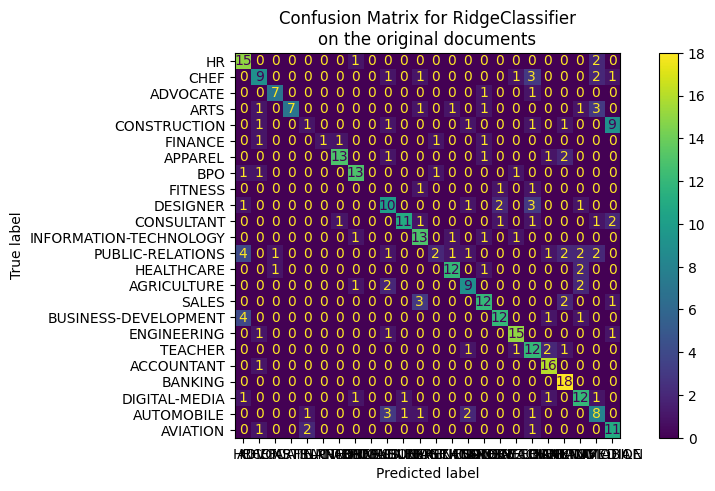

In [34]:
vectorizer = TfidfVectorizer(
        sublinear_tf=True,  min_df=5,ngram_range=(1,2), stop_words="english"
    )
clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

len(set(pred))

target_names = set(df.Category)

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non the original documents"
)

In [35]:
# Evaluation

## Acuracy, Precision, Recall, F1-Score



accuracy_score(y_test, pred)

print(precision_score(y_test, pred, average='macro'))
print(precision_score(y_test, pred, average='micro'))
print(precision_score(y_test, pred, average='weighted'))


print(recall_score(y_test, pred, average='macro'))
print(recall_score(y_test, pred, average='micro'))
print(recall_score(y_test, pred, average='weighted'))


print(f1_score(y_test, pred, average='macro'))
print(f1_score(y_test, pred, average='micro'))
print(f1_score(y_test, pred, average='weighted'))

# Benchmarking classifiers





results = []
for clf, name in (
    (LogisticRegression(C=5, max_iter=1000), "Logistic Regression"),
    (RidgeClassifier(alpha=1.0, solver="sparse_cg"), "Ridge Classifier"),
    (KNeighborsClassifier(n_neighbors=100), "kNN"),
    (RandomForestClassifier(), "Random Forest"),
    # L2 penalty Linear SVC
    (LinearSVC(C=0.1, dual=False, max_iter=1000), "Linear SVC"),
    # L2 penalty Linear SGD
    (
        SGDClassifier(
            loss="log_loss", alpha=1e-4, n_iter_no_change=3, early_stopping=True
        ),
        "log-loss SGD",
    ),
    # NearestCentroid (aka Rocchio classifier)
    (NearestCentroid(), "NearestCentroid"),
    # Sparse naive Bayes classifier
    (ComplementNB(alpha=0.1), "Complement naive Bayes"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf, name))

/home/ranamahmud/Documents/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ranamahmud/Documents/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.6342490350994607
0.6407506702412868
0.6456355917728854
0.6040324463118582
0.6407506702412868
0.6407506702412868
0.5898149735787493
0.6407506702412868
0.6204810039874485
Logistic Regression
________________________________________________________________________________
Training: 
LogisticRegression(C=5, max_iter=1000)
train time: 8.15s
test time:  0.0124s
accuracy:   0.633
f1_score macro:   0.587
f1_score micro:   0.633
f1_score weighted:   0.615
dimensionality: 5371
density: 1.0


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sparse_cg')
train time: 0.194s
test time:  0.000633s
accuracy:   0.641
f1_score macro:   0.59
f1_score micro:   0.641
f1_score weighted:   0.62
dimensionality: 5371
density: 1.0


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=100)
train time: 0.00111s
test time:  0.0284s
accuracy:   0.501
f1_sc

From the unigram and bigram model we fitted the following models in our data for classifying resumes. But didn't got good performance. LogisticRegression, RidgeClassifier, KNeighborsClassifier,RandomForestClassifier,LinearSVC,SGDClassifier,NearestCentroid,ComplementNB
We didn't good performance for classifying Resume as all the models had accuracy, f1 score less than 0.70.

# distilbert-base-uncased

In [36]:
# %pip install transformers
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# %pip install ipywidgets

In [37]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

/home/ranamahmud/Documents/venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [38]:
def preprocess_function(text):
    return tokenizer(text, truncation=True)

In [39]:
 df['Resume_str']

0        Service Manager with 15+ years of experience ...
1       ound in Communications, Marketing, Human Resou...
2       uman Resources Executive Management,   5 years...
3       r service expertise. Motivated to maintain cus...
4       rganization Startups  Employment Law  FMLA/ADA...
                              ...                        
2479    Motivated logistics specialist, successful at ...
2480    onal Summary    Strategically grounded, highly...
2481    ss multiple disciplines including technical\ns...
2482    sional with 9 plus years of experience in admi...
2483    sponsible career position that fully utilizes ...
Name: Resume_str, Length: 2484, dtype: object

In [40]:
tokenized_resume = df['Resume_str'].apply(lambda text: tokenizer(text, truncation=True))

In [41]:
tokenized_resume

0       [input_ids, attention_mask]
1       [input_ids, attention_mask]
2       [input_ids, attention_mask]
3       [input_ids, attention_mask]
4       [input_ids, attention_mask]
                   ...             
2479    [input_ids, attention_mask]
2480    [input_ids, attention_mask]
2481    [input_ids, attention_mask]
2482    [input_ids, attention_mask]
2483    [input_ids, attention_mask]
Name: Resume_str, Length: 2484, dtype: object

In [42]:
# %pip install evaluate

In [43]:
import evaluate
accuracy = evaluate.load("accuracy")

In [44]:
categories = df.Category.unique()
id2label = {label: idx for idx, label in enumerate(categories)}
label2id = {idx: label for idx, label in enumerate(categories)}

In [45]:
id2label

{'HR': 0,
 'DESIGNER': 1,
 'INFORMATION-TECHNOLOGY': 2,
 'TEACHER': 3,
 'ADVOCATE': 4,
 'BUSINESS-DEVELOPMENT': 5,
 'HEALTHCARE': 6,
 'FITNESS': 7,
 'AGRICULTURE': 8,
 'BPO': 9,
 'SALES': 10,
 'CONSULTANT': 11,
 'DIGITAL-MEDIA': 12,
 'AUTOMOBILE': 13,
 'CHEF': 14,
 'FINANCE': 15,
 'APPAREL': 16,
 'ENGINEERING': 17,
 'ACCOUNTANT': 18,
 'CONSTRUCTION': 19,
 'PUBLIC-RELATIONS': 20,
 'BANKING': 21,
 'ARTS': 22,
 'AVIATION': 23}

In [46]:
# save id2label to json
with open('id2label.json', 'w') as json_file:
    json.dump(id2label, json_file, indent=4)

In [47]:
label2id

{0: 'HR',
 1: 'DESIGNER',
 2: 'INFORMATION-TECHNOLOGY',
 3: 'TEACHER',
 4: 'ADVOCATE',
 5: 'BUSINESS-DEVELOPMENT',
 6: 'HEALTHCARE',
 7: 'FITNESS',
 8: 'AGRICULTURE',
 9: 'BPO',
 10: 'SALES',
 11: 'CONSULTANT',
 12: 'DIGITAL-MEDIA',
 13: 'AUTOMOBILE',
 14: 'CHEF',
 15: 'FINANCE',
 16: 'APPAREL',
 17: 'ENGINEERING',
 18: 'ACCOUNTANT',
 19: 'CONSTRUCTION',
 20: 'PUBLIC-RELATIONS',
 21: 'BANKING',
 22: 'ARTS',
 23: 'AVIATION'}

In [48]:
# conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia

In [49]:
# %pip install transformers[torch]

In [50]:
# %pip install accelerate -U
# %pip install transformers[torch]

In [51]:
df.head()

,ID,Resume_str,Resume_html,Category,cleaned_resume
0,16852973,Service Manager with 15+ years of experience ...,"<div class=""fontsize fontface vmargins hmargin...",HR,servic manag year experi hospit custom servic ...
1,22323967,"ound in Communications, Marketing, Human Resou...","<div class=""fontsize fontface vmargins hmargin...",HR,ound commun market human resourc technolog exp...
2,33176873,"uman Resources Executive Management, 5 years...","<div class=""fontsize fontface vmargins hmargin...",HR,uman resourc execut manag year hri develop mai...
3,27018550,r service expertise. Motivated to maintain cus...,"<div class=""fontsize fontface vmargins hmargin...",HR,r servic expertis motiv maintain custom satisf...
4,17812897,rganization Startups Employment Law FMLA/ADA...,"<div class=""fontsize fontface vmargins hmargin...",HR,rganiz startup employ law mediat advocaci hr p...


In [52]:
huggingface_model_name = 'distilbert-base-uncased'

In [53]:



# Prepare label mappings
categories = df['Category'].unique()
id2label = {idx: label for idx, label in enumerate(categories)}
label2id = {label: idx for idx, label in enumerate(categories)}
df['labels'] = df['Category'].map(label2id)

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(huggingface_model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    huggingface_model_name, 
    num_labels=len(categories), 
    id2label=id2label, 
    label2id=label2id
)

# Tokenize the Resume_str column
def tokenize_function(examples):
    return tokenizer(examples['Resume_str'], truncation=True, padding='max_length', max_length=512)

# Tokenize dataset
tokenized_resumes = df[['Resume_str', 'labels']].apply(tokenize_function, axis=1)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    tokenized_resumes, 
    df['labels'], 
    test_size=0.2, 
    random_state=42, 
    stratify=df['labels']
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, 
    y_train, 
    test_size=0.25,  # 0.25 * 0.8 = 0.2
    random_state=42, 
    stratify=y_train
)

# Prepare datasets for Hugging Face Trainer
train_dataset = Dataset.from_pandas(pd.DataFrame({
    'input_ids': [x['input_ids'] for x in X_train], 
    'attention_mask': [x['attention_mask'] for x in X_train],
    'labels': y_train
}))

/home/ranamahmud/Documents/venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:

test_dataset = Dataset.from_pandas(pd.DataFrame({
    'input_ids': [x['input_ids'] for x in X_test],
    'attention_mask': [x['attention_mask'] for x in X_test],
    'labels': y_test
}))

In [55]:
valid_dataset = Dataset.from_pandas(pd.DataFrame({
    'input_ids': [x['input_ids'] for x in X_valid],
    'attention_mask': [x['attention_mask'] for x in X_valid],
    'labels': y_valid
}))

# Define training arguments
training_args = TrainingArguments(
    output_dir="resume_classification",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=30,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    acc = accuracy_score(p.label_ids, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

from transformers import EarlyStoppingCallback
# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train the model
trainer.train()

# Evaluate the model
trainer.evaluate()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,2.828601,0.420523,0.389580,0.420523,0.356679
2,No log,2.213694,0.547284,0.445326,0.547284,0.470055
3,No log,1.765684,0.653924,0.654558,0.653924,0.604725
4,No log,1.428346,0.722334,0.760489,0.722334,0.686817
5,No log,1.171756,0.790744,0.782123,0.790744,0.772022
6,No log,1.031817,0.800805,0.789354,0.800805,0.784513
7,No log,0.934666,0.808853,0.794326,0.808853,0.794770
8,No log,0.891870,0.816901,0.796753,0.816901,0.803106
9,No log,0.867441,0.812877,0.795662,0.812877,0.802171
10,No log,0.863099,0.814889,0.804877,0.814889,0.797622


/home/ranamahmud/Documents/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ranamahmud/Documents/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ranamahmud/Documents/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

/home/ranamahmud/Documents/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.8397436141967773,
 'eval_accuracy': 0.8189134808853119,
 'eval_precision': 0.8007768163999027,
 'eval_recall': 0.8189134808853119,
 'eval_f1': 0.8070818261139289,
 'eval_runtime': 1.0932,
 'eval_samples_per_second': 454.644,
 'eval_steps_per_second': 14.636,
 'epoch': 13.0}

In [56]:
# Evaluate on test set (final evaluation)
print("Test Set Performance:")
test_results = trainer.evaluate(eval_dataset=test_dataset)
print(test_results)

Test Set Performance:
{'eval_loss': 0.726285994052887, 'eval_accuracy': 0.8269617706237424, 'eval_precision': 0.8171643144088377, 'eval_recall': 0.8269617706237424, 'eval_f1': 0.8184141959598527, 'eval_runtime': 1.0941, 'eval_samples_per_second': 454.27, 'eval_steps_per_second': 14.624, 'epoch': 13.0}


/home/ranamahmud/Documents/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Rational Behind using distilbert-base-uncased model

As classical machine learning models don't perform well on resume classification tasks, I've experimented with finetuning distilbert-base-uncased. The resume dataset had a class imbalance problem. For this reason, I've chosen the f1 score to measure model performance based on a valid set f1 score of 0.80 and test f1 score of 0.81, validation accuracy of 0.81, test data set accuracy of 0.82. This model generalized well on unseen data. I've decided to use this model for the final terminal application.

## Save model

In [57]:
model_save_path = "./resume_classification_model"


In [58]:
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

('./resume_classification_model/tokenizer_config.json',
 './resume_classification_model/special_tokens_map.json',
 './resume_classification_model/vocab.txt',
 './resume_classification_model/added_tokens.json',
 './resume_classification_model/tokenizer.json')

# Inference Helper and Testing

In [59]:
def load_model_and_tokenizer(path):
    model = AutoModelForSequenceClassification.from_pretrained(path)
    tokenizer = AutoTokenizer.from_pretrained(path)
    return model, tokenizer

In [60]:
model, tokenizer = load_model_and_tokenizer(model_save_path)

In [61]:
df.head()

,ID,Resume_str,Resume_html,Category,cleaned_resume,labels
0,16852973,Service Manager with 15+ years of experience ...,"<div class=""fontsize fontface vmargins hmargin...",HR,servic manag year experi hospit custom servic ...,0
1,22323967,"ound in Communications, Marketing, Human Resou...","<div class=""fontsize fontface vmargins hmargin...",HR,ound commun market human resourc technolog exp...,0
2,33176873,"uman Resources Executive Management, 5 years...","<div class=""fontsize fontface vmargins hmargin...",HR,uman resourc execut manag year hri develop mai...,0
3,27018550,r service expertise. Motivated to maintain cus...,"<div class=""fontsize fontface vmargins hmargin...",HR,r servic expertis motiv maintain custom satisf...,0
4,17812897,rganization Startups Employment Law FMLA/ADA...,"<div class=""fontsize fontface vmargins hmargin...",HR,rganiz startup employ law mediat advocaci hr p...,0


In [62]:
def classify_resume(resume, model, tokenizer):
    # Tokenize the input text
    inputs = tokenizer(resume, truncation=True, padding='max_length', max_length=512, return_tensors="pt")
    
    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get the predicted label (output logits -> predicted class)
    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=1).item()
    
    return id2label[predicted_class_id]

In [63]:
classify_resume(df.Resume_str[0], model, tokenizer)

'HR'

In [64]:
classify_resume(df.Resume_str[200], model, tokenizer)

'DESIGNER'

In [65]:
id2label[1]

'DESIGNER'

In [66]:
df.Category[200]

'DESIGNER'

# Read pdf and do classification on a sample file

In [67]:
from pypdf import PdfReader

In [68]:
def read_pdf(file):
    reader = PdfReader(file)
    text = [page.extract_text() for page in reader.pages]
    # remove first line to remove data leackage
    return ' '.join(text)

In [69]:
file = read_pdf("/home/ranamahmud/Documents/resume-classification/data/data/ACCOUNTANT/10554236.pdf")[20:]
file[0:50]

'inancial Accountant specializing in financial plan'

In [70]:
classify_resume(file, model, tokenizer)

'ACCOUNTANT'

In [71]:
id2label[18]

'ACCOUNTANT'

In [72]:
import os
def get_pdf_files_from_directory(directory):
    """Recursively get all PDF files from the given directory."""
    pdf_files = []
    
    # Traverse the directory
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.pdf'):  # Check for PDF files
                pdf_files.append(os.path.join(root, file))
    
    return pdf_files

In [73]:
pdf_files = get_pdf_files_from_directory("./data/data/")

In [74]:
pdf_files[0:5]

['./data/data/INFORMATION-TECHNOLOGY/19850482.pdf',
 './data/data/INFORMATION-TECHNOLOGY/13405733.pdf',
 './data/data/INFORMATION-TECHNOLOGY/28672970.pdf',
 './data/data/INFORMATION-TECHNOLOGY/15651486.pdf',
 './data/data/INFORMATION-TECHNOLOGY/24889109.pdf']

In [75]:
file = pdf_files[0]
classify_resume(file, model, tokenizer)

'INFORMATION-TECHNOLOGY'

In [76]:
file = pdf_files[1000]
classify_resume(file, model, tokenizer)

'ACCOUNTANT'

In [77]:
pdf_files[1000]

'./data/data/ACCOUNTANT/24103168.pdf'